# Variational Regression

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
from scipy.stats   import multivariate_normal as Normal
from scipy.stats   import norm
from scipy.special import gamma as gam_fun
from scipy.special import digamma
from scipy.linalg  import pinv as inv
from scipy.linalg  import det

from sklearn.preprocessing import PolynomialFeatures
from IPython.display import Image

---
##### Summary
* *Goals*:
    1. Implement the Coordinate Ascent Variational Inference (CAVI) algorithm to approximate the posterior of a fully Bayesian model (see *Details*).
* *Methods*:
    1. See details of the CAVI algorithm below.

* *Details*:
    1. [Variational Inference: A Review for Statisticians, Blei et al. (2018)](https://arxiv.org/pdf/1601.00670.pdf)
    2. PRML, Chapter 10, Bishop. (2005)
---

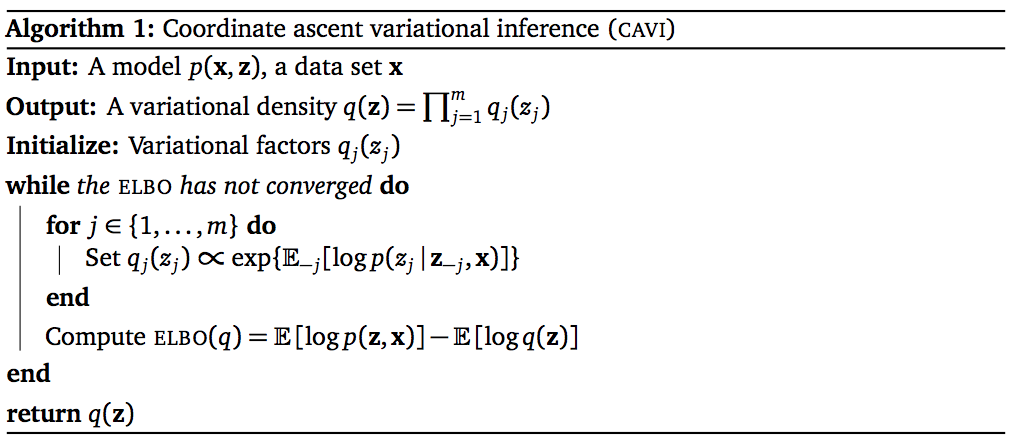

In [2]:
Image('./images/cavi.png', width=600)

The model's full joint distribution is given by:
\begin{align}
p(t, w, \alpha, \beta) = p(t| \beta, w)p(w| \alpha)p(\alpha)p(\beta),
\end{align}
where:
\begin{align}
p(t| \beta, w) &= \mathcal{N}(t | \Phi w, \beta^{-1}\mathbb{1}),\\
p(w| \alpha)   &= \mathcal{N}(w | 0, \alpha^{-1}\mathbb{1}),\\
p(\alpha)      &= \mathrm{Ga}(\alpha | a_0, b_0),\\
p(\beta)       &= \mathrm{Ga}(\beta | c_0, c_0).
\end{align}


We approximate the true posterior using the variational distribution $q(w, \alpha, \beta) = q(w)q(\alpha)q(\beta)$, which can be found by:

\begin{align}
\ln q^*(w)      &= \mathbb{E}_{\alpha, \beta}\left[\ln p(t| \beta, w)+ \ln p(w)\right] + \mathrm{const.}\\
\ln q^*(\alpha) &= \mathbb{E}_{\beta, w}\left[\ln p(w|\alpha) + \ln p(\alpha)\right] + \mathrm{const.}\\
\ln q^*(\beta)  &= \mathbb{E}_{\alpha, w}\left[\ln p(t| \beta, w) + \ln p(\beta)\right] + \mathrm{const.}\ .
\end{align}


The evidence lower bound is made up of seven terms:

\begin{align}
\textrm{ELBO} = \underbrace{\mathbb{E}_{w, \beta}[\ln p(t|\beta, w)]}_{T_1} + \underbrace{\mathbb{E}_{w, \alpha}[\ln p(w| \alpha)]}_{T_2} + \underbrace{\mathbb{E}_{\alpha}[\ln p(\alpha)]}_{T_3} + \underbrace{\mathbb{E}_{\beta}[\ln p(\beta)]}_{T_4} - \underbrace{\mathbb{E}_{\alpha}[\ln q^*(\alpha)]}_{T_5} - \underbrace{\mathbb{E}_{\beta}[\ln q^*(\beta)]}_{T_6} - \underbrace{\mathbb{E}_{w}[\ln q^*(w)]}_{T_7}. 
\end{align}

In [3]:
class Gamma:
    """Simple implementation of the Gamma distribution."""
    def __init__(self, scale, rate):
        self.scale = scale
        self.rate = rate
    def pdf(self, x):
        a, b = self.scale, self.rate
        return (1/gam_fun(a))*(b**a)*(x**(a-1))*np.exp(-b*x)
    def expectation(self):
        return self.scale/self.rate

def polynomial_basis_fn(D, degree):
    poly = PolynomialFeatures(degree=degree)
    return poly.fit_transform(D)

def CAVI(degree=2, n_iters=40):
    phi = polynomial_basis_fn(X, degree)

    D, N = phi.shape  # (number examples, number parameters)
    a_0 = b_0 = c_0 = d_0 = 0.1  # uninformative priors
    m_n, S_n = np.random.uniform(
        size=(N, 1)), np.random.uniform(size=(N, 1)) * np.eye(N)
    # init qs
    q_w = Normal(m_n[:, 0], S_n)
    q_a = Gamma(a_0, b_0)
    q_b = Gamma(c_0, d_0)
    lower_bound = []

    for i in range(n_iters):
        # update variational factors' parameters
        a_n = a_0 + N / 2
        b_n = b_0 + .5 * (np.trace(S_n) + m_n.T @ m_n)
        q_a.scale, q_a.rate = a_n, b_n[0][0]
        c_n = c_0 + D / 2
        d_n = d_0 + .5 * (t.T @ t - 2 * t.T @ phi @ m_n + np.trace(phi @ (S_n + m_n @ m_n.T) @ phi.T))
        q_b.scale, q_b.rate = c_n, d_n[0][0]
        S_n = inv((c_n / d_n[0][0]) * phi.T @ phi + (a_n / b_n[0][0]) * np.eye(N))
        m_n = (c_n / d_n) * S_n @ phi.T @ t
        q_w.mean, q_w.cov = m_n, S_n

        # compute the evidence lower bound (as a sum of seven expectations)
        b_n, d_n = b_n[0, 0], d_n[0, 0]
        T_1 = -(D / 2) * (np.log(2 * np.pi) - digamma(c_n) + np.log(d_n)) - .5 * (c_n / d_n) *\
            (t.T @ t - 2 * m_n.T @ phi.T @ t + np.trace(phi @ (S_n + m_n @ m_n.T) @ phi.T))[0, 0]
        T_2 = (N / 2) * (digamma(a_n) - np.log(b_n) - np.log(2 * np.pi)) - .5 * (a_n / b_n) *\
            (np.trace(S_n) + m_n.T @ m_n)[0, 0]
        T_3 = -np.log(gam_fun(a_0)) + a_0 * np.log(b_0) + (a_0 - 1) *\
            (digamma(a_n) - np.log(b_n)) - b_0 * (a_n / b_n)
        T_4 = -np.log(gam_fun(c_0)) + c_0 * np.log(d_0) + (c_0 - 1) *\
            (digamma(c_n) - np.log(d_n)) - d_0 * (c_n / d_n)
        T_5 = np.log(gam_fun(a_n) / b_n) - (a_n - 1) * digamma(a_n) + a_n
        T_6 = np.log(gam_fun(c_n) / d_n) - (c_n - 1) * digamma(c_n) + c_n
        T_7 = .5 * (np.log(det(S_n))) + (N / 2) * (1 + np.log(2 * np.pi))
        lower_bound.append(T_1 + T_2 + T_3 + T_4 + T_5 + T_6 + T_7)

    return lower_bound, q_w, q_b, q_a


25 examples, polynomial degree = 2


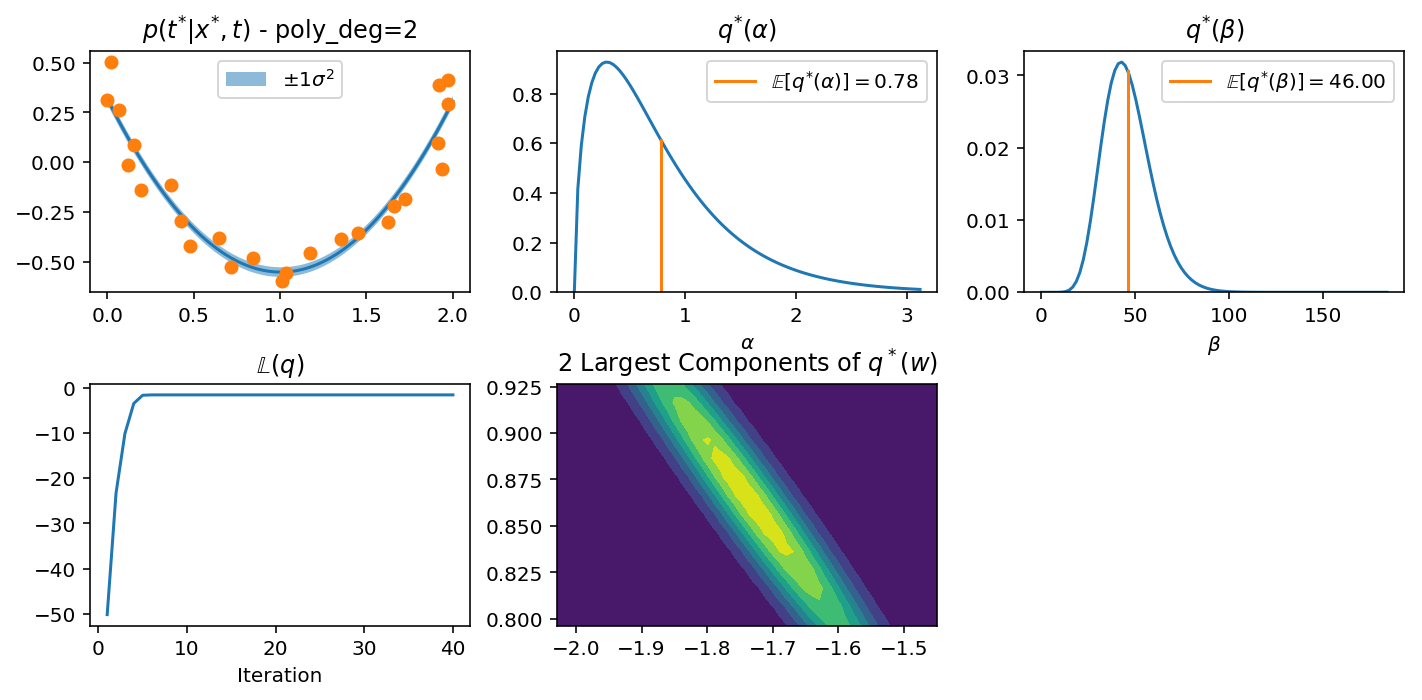

In [4]:
# dataset
n = 25
noise = 0.05
x = 1 - np.cos(np.linspace(0, np.pi, n)) + np.random.normal(scale=noise, size=n)
t = 1 - np.sin(np.linspace(0, np.pi, n)) + np.random.normal(scale=noise, size=n) -.5
t = np.expand_dims(t, axis=1)
#plt.plot(x, t[:,0], 'o')
X = x[:,None];

degree = 2
n_iters = 40
lower_bound, q_w, q_b, q_a = CAVI(degree, n_iters=n_iters)
m_n, S_n = q_w.mean, q_w.cov
x_range = np.linspace(0,2,100)
phi_range = polynomial_basis_fn(x_range[:,None], degree)
sig_sq = np.diag(phi_range @ q_w.cov @ phi_range.T) + q_b.rate/q_b.scale
mean = (phi_range @ q_w.mean)[:,0]
plt.figure(figsize=(10,5))
plt.subplot(231)
plt.title(r'$p(t^{*}|x^{*}, t)$'+f' - poly_deg={degree}')
plt.plot(x_range, mean)
plt.fill_between(x_range, mean+1*sig_sq, mean-1*sig_sq, alpha=0.5, label=r'$\pm1\sigma^2$')
plt.plot(x, t[:,0], 'o')
plt.legend(loc=0)

plt.subplot(232)
plt.title(r'$q^{*}(\alpha)$')
plt.plot(2*q_a.expectation()*x_range, q_a.pdf(2*q_a.expectation()*x_range))
plt.xlabel(r'$\alpha$')
a = q_a.expectation()
plt.plot([a,a], [0,q_a.pdf(a)], label=r'$\mathbb{E}[q^{*}(\alpha)]=$'+f'{a:.2f}')
plt.ylim(0,)
plt.legend(loc=0)

plt.subplot(233)
plt.title(r'$q^{*}(\beta)$')
plt.plot(2*q_b.expectation()*x_range, q_b.pdf(2*q_b.expectation()*x_range))
plt.xlabel(r'$\beta$')
b = q_b.expectation()
plt.plot([b,b], [0,q_b.pdf(b)], label=r'$\mathbb{E}[q^{*}(\beta)]=$'+f'{b:.2f}')
plt.ylim(0,)
plt.legend(loc=0)

plt.subplot(234)
plt.title(r'$\mathbb{L}(q)$')
plt.xlabel('Iteration')
plt.plot(range(1, n_iters+1), lower_bound)
print(f'{n} examples, polynomial degree = {degree}')
plt.tight_layout();

plt.subplot(235) # covariance plot
plt.title(r'2 Largest Components of $q^*(w)$')
#ids = np.argsort(np.diag(S_n))[::-1][:2]
ids = np.argsort(np.abs(m_n[:,0]))[::-1][:2]
reduced_cov = np.array([[S_n[ids[0],ids[0]], S_n[ids[0],ids[1]]],
                        [S_n[ids[1],ids[0]], S_n[ids[1],ids[1]]]])
reduced_mean = np.array([m_n[ids[0]],
                         m_n[ids[1]]]) 
weights_vis = Normal(reduced_mean[:,0], reduced_cov)
scale_ = 10
x_low  = reduced_mean[0,0] - scale_ * reduced_cov[0,0]
x_high = reduced_mean[0,0] + scale_ * reduced_cov[0,0]
y_low  = reduced_mean[1,0] - scale_ * reduced_cov[1,1]
y_high = reduced_mean[1,0] + scale_ * reduced_cov[1,1]
g1, g2 = np.meshgrid(np.arange(x_low, x_high, 0.01), np.arange(y_low, y_high, 0.01))
g = np.c_[g1.ravel(), g2.ravel()]
g_pred = weights_vis.pdf(g).reshape(*g1.shape)
plt.contourf(g1, g2, g_pred);

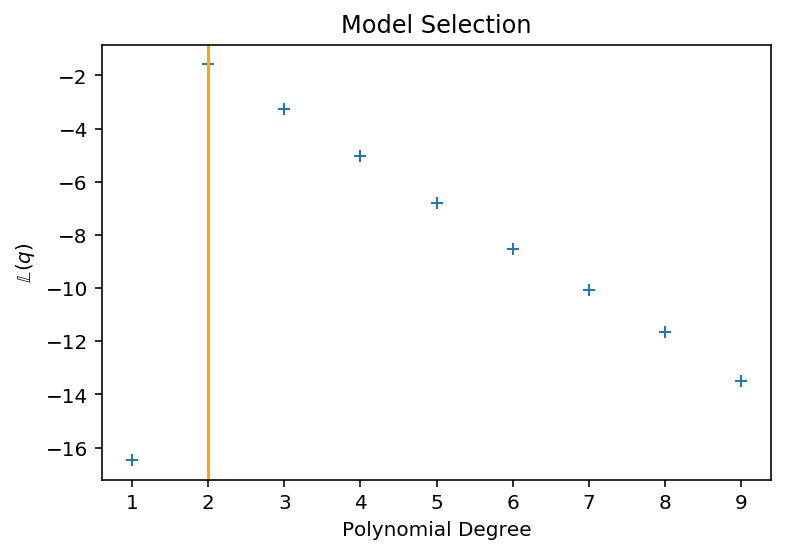

In [5]:
lb = []
deg_range = range(1,10)
for degree in deg_range:
    n_iters = 40
    lower_bound, q_w, q_b, q_a = CAVI(degree, n_iters=n_iters)
    lb.append(lower_bound[-1])

plt.plot(deg_range, lb, '+')
plt.axvline(np.argmax(lb)+1, color='orange')
plt.title('Model Selection')
plt.xlabel('Polynomial Degree')
plt.ylabel(r'$\mathbb{L}(q)$');